In [ ]:
from dotenv import load_dotenv
import os, pathlib

load_dotenv()                                   # pulls .env into env-vars
print("DEEPSEEK_API_KEY" in os.environ)  

In [ ]:
### 
# DEPRICATED FILE -> FTAAT.ipynb
# Reference visualization maybe
###



import openai
import random
import string
import tiktoken
import pandas as pd
import json
from datetime import datetime
from pathlib import Path
# Imports
openai.api_key = "" 
# Log Directory
LOG_DIR = Path("experiment_logs")
LOG_DIR.mkdir(exist_ok=True)

# Model
MODEL_NAME = "gpt-3.5-turbo"
ENCODING_NAME = "gpt-3.5-turbo"

# For token counting
encoding = tiktoken.encoding_for_model(ENCODING_NAME)


In [5]:
# Load Token Set
filename = "data/tokens/alpha_tokens.json"
with open(filename, 'r') as f:
        token_set = set(json.load(f))

In [6]:
def count_gpt_tokens(text: str) -> int:
    """Return how many tokens `text` uses under the GPT-3.5 (or GPT-4) tokenizer."""
    return len(encoding.encode(text))

def query_gpt(prompt: str, model: str = MODEL_NAME, temperature: float = 0.0) -> str:
    """
    Calls OpenAI's ChatCompletion API with the given prompt,
    returns the assistant's message content.
    """
    response = openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant. Respond with only the correct answer on each line."},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature
    )
    return response["choices"][0]["message"]["content"].strip()

In [25]:

def log_experiment(record):
    """Log full experiment details in structured JSON format"""
    # Create unique experiment ID
    experiment_id = f"{record['num_facts']}f_{record['k']}k_{record['trial']}t_{datetime.now().strftime('%H%M%S')}"
    
    # Create experiment-specific log file
    log_file = LOG_DIR / f"exp_{experiment_id}.json"
    
    # Add additional metadata
    record.update({
        "timestamp": datetime.now().isoformat(),
        "experiment_id": experiment_id,
        "model": MODEL_NAME,
    })
    
    # Convert non-serializable objects
    formatted_record = {
        k: str(v) if not isinstance(v, (int, float, str, bool, list, dict)) else v
        for k, v in record.items()
    }
    
    with open(log_file, 'w') as f:
        json.dump(formatted_record, f, indent=2)

def log_mismatch_details(record):
    """Log detailed mismatch information separately"""
    mismatch_file = LOG_DIR / "mismatch_details.ndjson"
    
    mismatch_entry = {
        "experiment_id": record["experiment_id"],
        "timestamp": datetime.now().isoformat(),
        "num_facts": record["num_facts"],
        "k": record["k"],
        "trial": record["trial"],
        "accuracy": record["accuracy"],
        "prompt_text": record["prompt_text"],
        "expected_answers": record["question_keys"],
        "actual_response": record["response"],
        "mismatches": record["mismatches"]
    }
    
    with open(mismatch_file, 'a') as f:
        f.write(json.dumps(mismatch_entry) + '\n')

In [26]:
def generate_unique_sequence(k: int, single_token_pool, used_sequences: set) -> str:
    """
    Randomly pick `k` single tokens from `single_token_pool`,
    join them with '|', and ensure it's never been used.
    """
    max_tries = 5000
    for _ in range(max_tries):
        chosen_tokens = random.sample(single_token_pool, k=k)
        seq = "|".join(chosen_tokens)
        if seq not in used_sequences:
            used_sequences.add(seq)
            return seq
    raise ValueError(f"Could not find a new {k}-token sequence after {max_tries} attempts.")

def generate_facts_k_tokens(num_facts: int, k: int, single_token_pool):
    """
    Generate `num_facts` lines, each of form:
        "Key: <k-token-seq> => Value: <k-token-seq>"
    where no key or value is repeated.
    Returns:
      facts_list: list of (fact_line, key_string, value_string)
      key_value_dict: mapping key_string -> value_string
    """
    used_sequences = set()
    facts_list = []
    key_value_dict = {}

    for _ in range(num_facts):
        key_seq = generate_unique_sequence(k, single_token_pool, used_sequences)
        val_seq = generate_unique_sequence(k, single_token_pool, used_sequences)
        fact_line = f"{key_seq} => {val_seq}"
        facts_list.append((fact_line, key_seq, val_seq))
        key_value_dict[key_seq] = val_seq

    return facts_list, key_value_dict

In [27]:
def build_prompt_for_all_keys(facts_list):
    """
    - Lists all facts in the prompt
    - Then lists all keys in random order, requesting the correct values
    in that same order.
    Returns:
       (prompt_str, question_keys_in_order)
    """
    # Combine fact lines in a single block
    facts_text = "\n".join(fact_line for (fact_line, _, _) in facts_list)

    # Extract keys in a random order
    all_keys = [key for (_, key, _) in facts_list]
    random.shuffle(all_keys)

    # We'll list them as "1) <key>" etc. 
    questions_text = "\n".join(f"{i+1}) {k}" for i, k in enumerate(all_keys))

    prompt = (
        "Below are some arbitrary assignments of Key => Value:\n\n"
        f"{facts_text}\n\n"
        "Your task is to provide the correct Values for each of the following Keys, "
        "in the exact same order they are listed:\n\n"
        f"{questions_text}\n\n"
        "Answer with one value per line, matching the order of the keys above."
    )
    return prompt, all_keys

In [28]:
# EXAMPLE PROMPT AND RESPONSE
single_token_vocab = list(token_set)
print("Single-token vocab size:", len(single_token_vocab))

# 5.2) Generate some facts
num_facts = 5
k = 3  # each key = 3 tokens, each value = 3 tokens
facts_list, key_value_dict = generate_facts_k_tokens(num_facts, k, single_token_vocab)

# 5.3) Build the big prompt that queries all keys in random order
prompt, question_keys_in_order = build_prompt_for_all_keys(facts_list)

print("=== Prompt (Debug) ===\n")
print(prompt)
prompt_len = count_gpt_tokens(prompt)
print(f"\nPrompt token length: {prompt_len}")

print("\n=== The correct ordering of values (reference) ===")
for key in question_keys_in_order:
    print(f"{key_value_dict[key]}")

# 5.4) Query GPT (uncomment if you have your key set up)
answer = query_gpt(prompt, model=MODEL_NAME, temperature=0.0)
print("\n=== GPT RESPONSE ===")
print(answer)


Single-token vocab size: 10000
=== Prompt (Debug) ===

Below are some arbitrary assignments of Key => Value:

erg|blas|ingly => ismet|apt|letic
ossa|wd|ligne => off|ofday|oes
pop|avra|ikes => laden|aupt|iculo
bere|hem|cca => ffic|ammad|vore
llx|edin|hasil => lobs|autos|avy

Your task is to provide the correct Values for each of the following Keys, in the exact same order they are listed:

1) erg|blas|ingly
2) llx|edin|hasil
3) ossa|wd|ligne
4) bere|hem|cca
5) pop|avra|ikes

Answer with one value per line, matching the order of the keys above.

Prompt token length: 154

=== The correct ordering of values (reference) ===
ismet|apt|letic
lobs|autos|avy
off|ofday|oes
ffic|ammad|vore
laden|aupt|iculo

=== GPT RESPONSE ===
ismet|apt|letic
lobs|autos|avy
off|ofday|oes
ffic|ammad|vore
laden|aupt|iculo


In [29]:
def grade_response(response_text: str, question_keys_in_order: list, key_value_dict: dict):
    """
    Parses the GPT response line-by-line. We expect it to list the values
    in the same order as question_keys_in_order.

    Returns:
      accuracy: fraction of lines that match exactly
      num_matches: how many lines matched 
      total: how many lines we expected
      mismatch_details: list of (expected, got) for each mismatch
    """
    # Split lines, strip whitespace
    lines = [l.strip() for l in response_text.split("\n") if l.strip()]
    # lines now might contain numbering, e.g. "1) Pk am ub" or just "Pk am ub".

    expected_count = len(question_keys_in_order)
    num_matches = 0
    mismatch_details = []

    # We'll iterate over min(len(lines), expected_count) 
    for i in range(expected_count):
        expected_value = key_value_dict[question_keys_in_order[i]]

        if i < len(lines):

            maybe_split = lines[i].split(")", 1)
            if len(maybe_split) == 2 and maybe_split[0].isdigit():
                candidate_answer = maybe_split[1].strip()  # e.g. "Pk am ub"
            else:
                candidate_answer = lines[i]

            if candidate_answer == expected_value:
                num_matches += 1
            else:
                mismatch_details.append((expected_value, candidate_answer))
        else:
            # We have fewer lines in the response than we expected
            mismatch_details.append((expected_value, "MISSING_LINE"))

    accuracy = num_matches / expected_count

    return accuracy, num_matches, expected_count, mismatch_details


In [41]:
def run_experiments(facts_list_sizes=[5, 10], token_sizes=[2, 3], trials=3):
    """Enhanced version with comprehensive logging"""
    single_token_vocab = list(token_set)
    
    records = []
    for num_facts in facts_list_sizes:
        for k in token_sizes:
            for trial_idx in range(trials):
                # Generate facts and prompt
                facts_list, key_value_dict = generate_facts_k_tokens(num_facts, k, single_token_vocab)
                prompt_text, question_keys = build_prompt_for_all_keys(facts_list)
                prompt_len = count_gpt_tokens(prompt_text)
                
                # Query GPT
                try:
                    response = query_gpt(prompt_text, model=MODEL_NAME, temperature=0.0)
                except Exception as e:
                    response = f"ERROR: {str(e)}"
                
                # Grade response
                accuracy, num_matches, total_questions, mismatches = grade_response(
                    response, question_keys, key_value_dict
                )
                
                # Build complete record
                record = {
                    "num_facts": num_facts,
                    "k": k,
                    "trial": trial_idx,
                    "prompt_text": prompt_text,  # Store actual prompt
                    "question_keys": question_keys,  # Store expected questions
                    "key_value_dict": key_value_dict,  # Store correct answers
                    "prompt_len": prompt_len,
                    "accuracy": accuracy,
                    "num_correct": num_matches,
                    "num_questions": total_questions,
                    "mismatches": mismatches,
                    "response": response,
                }
                
                # Log everything
                #log_experiment(record)
                # if accuracy < 1:
                #     log_mismatch_details(record)
                
                records.append(record)
                print(f"Completed: facts={num_facts}, k={k}, trial={trial_idx}, accuracy={accuracy:.2f}")
    
    return pd.DataFrame(records)

# Example usage (Uncomment once you have your API key set):
#results_df = run_experiments(facts_list_sizes=[50, 100, 150 ,200, 250,300,350,400,450], token_sizes=[1,2,3,4], trials=4)
results_df = run_experiments(facts_list_sizes=[2,5,10,25,50,100], token_sizes=[1,2,5,10,25], trials=10)
#results_df.head()


Completed: facts=2, k=1, trial=0, accuracy=1.00
Completed: facts=2, k=1, trial=1, accuracy=1.00
Completed: facts=2, k=1, trial=2, accuracy=1.00
Completed: facts=2, k=1, trial=3, accuracy=1.00
Completed: facts=2, k=1, trial=4, accuracy=1.00
Completed: facts=2, k=1, trial=5, accuracy=1.00
Completed: facts=2, k=1, trial=6, accuracy=1.00
Completed: facts=2, k=1, trial=7, accuracy=1.00
Completed: facts=2, k=1, trial=8, accuracy=1.00
Completed: facts=2, k=1, trial=9, accuracy=1.00
Completed: facts=2, k=2, trial=0, accuracy=1.00
Completed: facts=2, k=2, trial=1, accuracy=1.00
Completed: facts=2, k=2, trial=2, accuracy=1.00
Completed: facts=2, k=2, trial=3, accuracy=1.00
Completed: facts=2, k=2, trial=4, accuracy=1.00
Completed: facts=2, k=2, trial=5, accuracy=1.00
Completed: facts=2, k=2, trial=6, accuracy=1.00
Completed: facts=2, k=2, trial=7, accuracy=1.00
Completed: facts=2, k=2, trial=8, accuracy=1.00
Completed: facts=2, k=2, trial=9, accuracy=0.00
Completed: facts=2, k=5, trial=0, accura

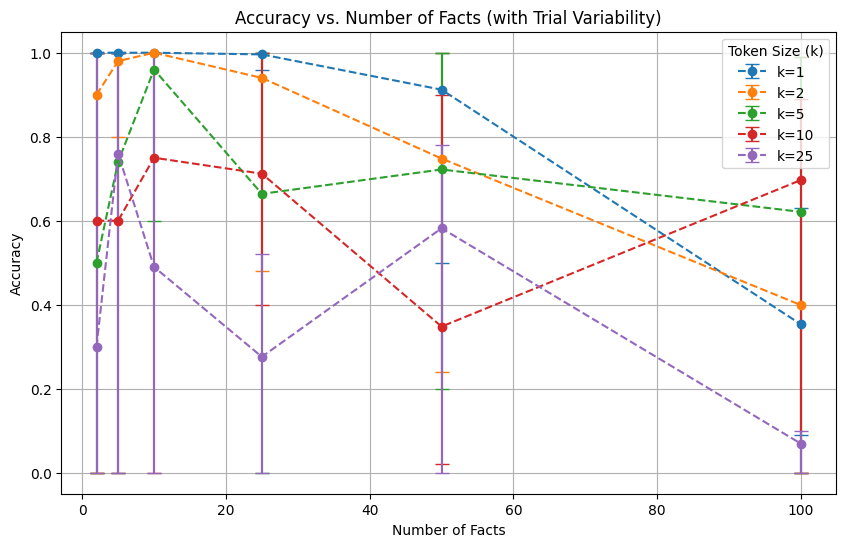

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group results by num_facts and k, then aggregate accuracy
summary_df = results_df.groupby(['num_facts', 'k'])['accuracy'].agg(
    ['mean', 'min', 'max']
).reset_index()

plt.figure(figsize=(10, 6))

# Plot lines for each k with error bars (min/max)
for k in summary_df['k'].unique():
    subset = summary_df[summary_df['k'] == k]
    plt.errorbar(
        subset['num_facts'], subset['mean'],
        yerr=[subset['mean'] - subset['min'], subset['max'] - subset['mean']],
        label=f'k={k}', marker='o', capsize=5, linestyle='--'
    )

plt.title('Accuracy vs. Number of Facts (with Trial Variability)')
plt.xlabel('Number of Facts')
plt.ylabel('Accuracy')
plt.legend(title='Token Size (k)')
plt.grid(True)
plt.show()

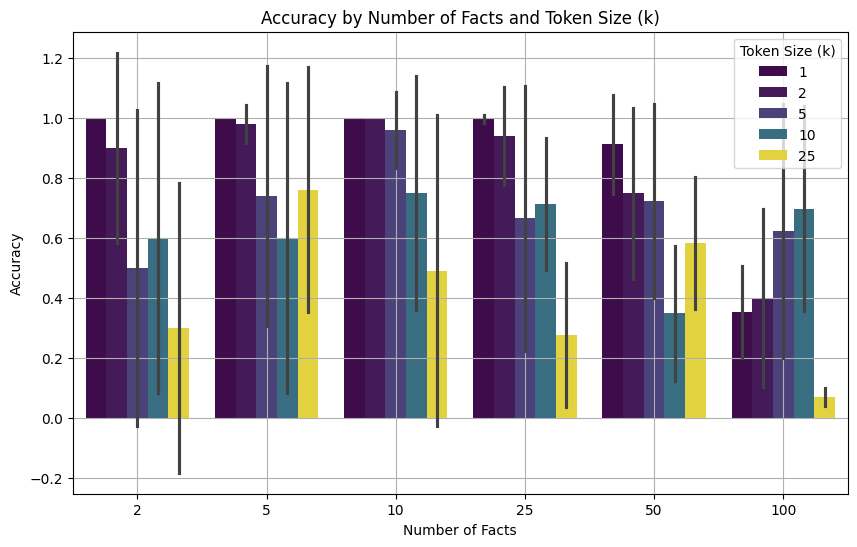

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x='num_facts', y='accuracy', hue='k',
    errorbar='sd',  # Show standard deviation
    palette='viridis'
)
plt.title('Accuracy by Number of Facts and Token Size (k)')
plt.xlabel('Number of Facts')
plt.ylabel('Accuracy')
plt.legend(title='Token Size (k)')
plt.grid(True)
plt.show()

In [33]:
def query_gpt_with_usage(prompt: str, model: str = MODEL_NAME, temperature: float = 0.0):
    """
    Calls the OpenAI ChatCompletion API with the given prompt,
    returns (assistant_message, prompt_tokens, completion_tokens).
    """
    response = openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant. Provide only the correct answer, do not include any unecessary text."},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature
    )
    assistant_msg = response["choices"][0]["message"]["content"].strip()
    usage = response["usage"]
    return assistant_msg, usage["prompt_tokens"], usage["completion_tokens"]


In [34]:
def build_prompt_subset(kb_facts_list, keys_to_ask):
    """
    - 'kb_facts_list': list of (fact_line, key, value) for the entire KB
    - 'keys_to_ask': list of keys (strings) from that KB we want the model to retrieve
    
    Returns a string prompt that:
      1) lists all facts in the KB
      2) asks for the values of the given subset of keys, labeled Q1, Q2, etc.
      3) instructs GPT to label answers Q1, Q2, etc. in any order
         (since we plan to parse them by label, not by order).
    """
    # We'll display each fact line with a numbering, e.g. "1) key => value"
    kb_text = "\n".join(f"{i+1}) {fact_line}" 
                        for i, (fact_line, _, _) in enumerate(kb_facts_list))

    # Then we list the subset of keys to ask about
    # We'll label them Q1, Q2, ...
    question_text = ""
    for i, key_str in enumerate(keys_to_ask):
        question_text += f"Q{i+1}: What is the value for the key '{key_str}'?\n"

    prompt = (
        "Below is a large set of arbitrary facts in the form 'Key => Value'. "
        f"{kb_text}\n\n"
        "Provide the values associated with the following keys."
        "each answer must be clearly labeled followed by your answer and nothing else."
        "Please label your answers with the same Q# as each question:\n\n"
        f"{question_text}\n"
    )
    return prompt


In [35]:
import re

def parse_and_grade_subset_response(gpt_response, keys_to_ask, kb_dict):
    """
    We expect the GPT response to have lines labeled Q1:, Q2:, etc.
    in any order. For each Q#, we compare the GPT answer with the known
    value from the KB.

    - 'keys_to_ask': a list of keys in the order [key_for_Q1, key_for_Q2, ...].
    - 'kb_dict': the full key->value dictionary.

    Returns: (accuracy, details_dict)
      accuracy = fraction of queries answered with an exact match
      details_dict = { "Q1": (expected_value, gpt_answer), "Q2": (expected, got), ...}
    """
    # Build a map from "Q1" -> expected_value
    expected_map = {}
    for i, key_str in enumerate(keys_to_ask):
        label = f"Q{i+1}"
        expected_val = kb_dict[key_str]
        expected_map[label] = expected_val

    # We'll parse the GPT response line by line, or use regex for lines that match "Q#: <something>"
    lines = gpt_response.split("\n")
    found_map = {}  # "Q1" -> "GPT's answer"

    pattern = re.compile(r"^(Q\d+)\s*:\s*(.*)", re.IGNORECASE)

    for line in lines:
        line = line.strip()
        match = pattern.match(line)
        if match:
            q_label = match.group(1)  # e.g. "Q2"
            answer_text = match.group(2).strip()
            found_map[q_label] = answer_text

    # Compare found answers with expected
    num_correct = 0
    total = len(keys_to_ask)
    details = {}

    for i, key_str in enumerate(keys_to_ask):
        label = f"Q{i+1}"
        expected_val = expected_map[label]
        got_val = found_map.get(label, None)  # None if GPT didn't provide Q#
        details[label] = (expected_val, got_val)

        if got_val == expected_val:
            num_correct += 1

    accuracy = num_correct / total
    return accuracy, details


In [36]:
def run_new_subset_tests(
    kb_sizes=[10, 20],
    k_values=[2, 3],
    ask_sizes=[3, 5],
    trials=2,
    vocab_size=2000
):
    """
    For each combination:
      - kb_size in kb_sizes (the total facts in the KB)
      - k in k_values (tokens per key or value)
      - ask_size in ask_sizes (# of keys to query from the KB)
    we run 'trials' times:
      1) Build a KB of kb_size facts
      2) Randomly pick 'ask_size' distinct keys
      3) Build prompt
      4) Query GPT, parse usage
      5) Parse & grade the response (order-independent)
      6) Store results in a DataFrame
    """

    # Reuse your existing single-token vocab generator (renamed if needed).
    single_token_vocab = build_single_token_pool(pool_size=vocab_size)

    records = []
    for kb_size in kb_sizes:
        for k_val in k_values:
            for ask_size in ask_sizes:
                for t in range(trials):
                    # 1) Generate KB
                    kb_facts_list, kb_dict = generate_facts_k_tokens(kb_size, k_val, single_token_vocab)

                    # 2) Pick random subset of keys to ask
                    all_keys = [info[1] for info in kb_facts_list]  # info = (fact_line, key, value)
                    if ask_size > len(all_keys):
                        ask_size = len(all_keys)  # or skip
                    ask_keys = random.sample(all_keys, ask_size)

                    # 3) Build prompt
                    prompt = build_prompt_subset(kb_facts_list, ask_keys)
                    local_prompt_len = count_gpt_tokens(prompt)

                    # 4) Query GPT
                    try:
                        gpt_answer, p_tokens, c_tokens = query_gpt_with_usage(prompt, MODEL_NAME, 0.0)
                    except Exception as e:
                        print("Error calling GPT:", e)
                        gpt_answer = "ERROR"
                        p_tokens = -1
                        c_tokens = -1

                    total_api_tokens = p_tokens + c_tokens if (p_tokens >= 0 and c_tokens >= 0) else -1

                    # 5) Parse & grade
                    if gpt_answer != "ERROR":
                        accuracy, details = parse_and_grade_subset_response(gpt_answer, ask_keys, kb_dict)
                    else:
                        accuracy, details = 0.0, {}

                    # 6) Store
                    record = {
                        "kb_size": kb_size,
                        "k_val": k_val,
                        "ask_size": ask_size,
                        "trial": t,
                        "prompt_len_tokens_local": local_prompt_len,
                        "prompt_tokens_api": p_tokens,
                        "completion_tokens_api": c_tokens,
                        "total_api_tokens": total_api_tokens,
                        "accuracy": accuracy,
                        "details": details,
                        "gpt_answer": gpt_answer,
                    }
                    log(record)
                    records.append(record)

                    print(f"[Test] kb_size={kb_size}, k={k_val}, ask_size={ask_size}, "
                          f"trial={t}, accuracy={accuracy:.2f}")

    df = pd.DataFrame(records)
    return df


In [37]:
# Example usage (uncomment if you have API key set):
results_df = run_new_subset_tests(
    kb_sizes=[100,250,500],
    k_values=[1,2,3,4],
    ask_sizes=[1,10,50],   # we only ask about 3 keys out of the 5 or 10 total
    trials=3,
    vocab_size=910
)
results_df.tail(10)


NameError: name 'build_single_token_pool' is not defined